In [1]:
from cheetah import Segment, ParticleBeam
import torch
import torch.nn as nn
import torch.nn.functional as F
import epics
import os
import numpy as np
import pprint
import h5py
from typing import List, Dict, Any, Callable
import yaml
import matplotlib.pyplot as plt
import math
import pprint
import pandas
beam = ParticleBeam.from_twiss(
    beta_x=torch.tensor(9.34),
    alpha_x=torch.tensor(-1.6946),
    emittance_x=torch.tensor(1e-7),
    beta_y=torch.tensor(9.34),
    alpha_y=torch.tensor(-1.6946),
    emittance_y=torch.tensor(1e-7),
    energy=torch.tensor(90e6),
    num_particles=10000,
    total_charge=torch.tensor(1e-9)
)
print(os.getcwd())
segment = Segment.from_lattice_json("../lattices/diag0bpm.json")


/Users/cgarnier/Desktop/sim/Linac-Simulation-Server/notebooks


In [2]:
with open('../yaml_configs/tracking_bpm.yaml', "r") as f:
    contents = yaml.safe_load(f)
df = pandas.DataFrame(contents)

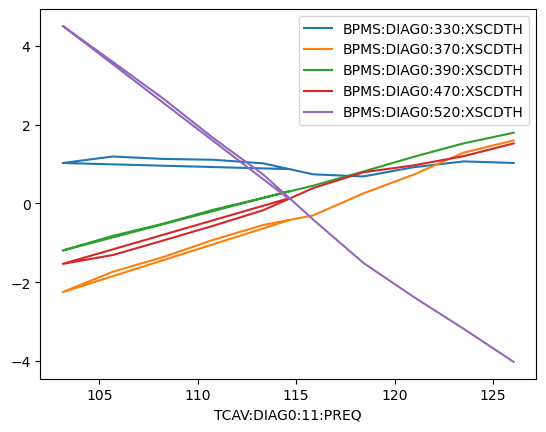

In [3]:

#filter process for tcav_phasing
tcav_phasing = df[df['process'] == 'tcav_phasing']
#filter on bpms and preq
tcav_phasing = tcav_phasing[[column for column in tcav_phasing.columns if 'BPM' in column or 'PREQ' in column]]
#filter out Y
tcav_phasing = tcav_phasing[[column for column in tcav_phasing.columns if 'Y' not in column]]
#filter out upstream of tcav (can filter on bpm and less then 330)
upstream_bpms = ['BPMS:DIAG0:190','BPMS:DIAG0:210', 'BPMS:DIAG0:230', 'BPMS:DIAG0:270', 'BPMS:DIAG0:285']
tcav_phasing = tcav_phasing[[column for column in tcav_phasing.columns if column.rsplit(':',1)[0] not in upstream_bpms ]]
tcav_phasing.plot(x='TCAV:DIAG0:11:PREQ')
phasing_dict = tcav_phasing.to_dict(orient='list')

In [4]:
phases = torch.tensor(phasing_dict['TCAV:DIAG0:11:PREQ'])
phases = phases/360
print(phases)

tensor([0.3183, 0.2865, 0.2936, 0.3006, 0.3077, 0.3148, 0.3219, 0.3289, 0.3360,
        0.3431, 0.3502])


In [5]:
#otr02 = segment.otrdg02.reading
#otr04 = segment.otrdg04.reading
#fig, axs = plt.subplots(2, 7, figsize=(20, 10))
#for i in range(7):
#    axs[0, i].imshow(otr02[i])
#    axs[1, i].imshow(otr04[i])


In [6]:
#data -> ctrl names
#ctrl name to madname
#madname to index
#index to tensor index -> return mu_x for device
#bpm data
ctrl_names = list(set([key.rsplit(':',1)[0] for key in phasing_dict.keys()]))
print(ctrl_names)
with open("../yaml_configs/DIAG0.yaml", "r") as f:
    data = yaml.safe_load(f)
bpm_data = data['bpms'].copy()

def ctrl_to_madname(controls_names:list[str],data: dict):
    madnames = []
    for name in controls_names:
        for key, value in data.items():
            try:
                if value["controls_information"]["control_name"] == name:
                    madnames.append(key.lower())
                    break
            except KeyError:
                continue
    return madnames

def names_to_index(names: list[str]):
    ind = []
    elements_to_index = segment.elements
    for index in range(len(elements_to_index)):
        if segment.elements[index].name in names:
            print(f'found {segment.elements[index].name} at index {index}')
            ind.append(index)
    return ind

['TCAV:DIAG0:11', 'BPMS:DIAG0:330', 'BPMS:DIAG0:390', 'BPMS:DIAG0:470', 'BPMS:DIAG0:370', 'BPMS:DIAG0:520']


In [7]:
madnames = ctrl_to_madname(ctrl_names, bpm_data)

In [8]:
ind = names_to_index(madnames)

found bpmdg0rf at index 181
found bpmdg008 at index 188
found bpmdg009 at index 194
found bpmdg011 at index 214
found bpmdg012 at index 220


In [9]:
segment.tcxdg0.voltage = torch.tensor(.135e6)
'''
for phase in phases:
    segment.tcxdg0.phase = phase
    tracked_beam = segment.track(beam)
    position_data = segment.get_beam_attrs_along_segment(("mu_x"),incoming=beam)

    mu_x = position_data[ind]
    print(mu_x)

    # need to convert to meters? idk
    # position of the bpms is in mm
'''

segment.tcxdg0.phase = phases
tracked_beam = segment.track(beam)
position_data = segment.get_beam_attrs_along_segment(("mu_x"),incoming=beam)
position_data.shape
vals = position_data[...,ind]
print(vals)
pprint.pprint(phasing_dict)

tensor([[ 1.3354e-05,  2.3031e-03,  1.7781e-03,  8.4010e-04, -9.8218e-03],
        [ 1.3354e-05,  2.4652e-03,  1.9037e-03,  8.9997e-04, -1.0518e-02],
        [ 1.3354e-05,  2.4374e-03,  1.8822e-03,  8.8971e-04, -1.0399e-02],
        [ 1.3354e-05,  2.4049e-03,  1.8570e-03,  8.7769e-04, -1.0259e-02],
        [ 1.3354e-05,  2.3676e-03,  1.8281e-03,  8.6394e-04, -1.0099e-02],
        [ 1.3354e-05,  2.3257e-03,  1.7956e-03,  8.4846e-04, -9.9192e-03],
        [ 1.3354e-05,  2.2793e-03,  1.7597e-03,  8.3131e-04, -9.7196e-03],
        [ 1.3354e-05,  2.2284e-03,  1.7202e-03,  8.1251e-04, -9.5009e-03],
        [ 1.3354e-05,  2.1732e-03,  1.6774e-03,  7.9210e-04, -9.2634e-03],
        [ 1.3354e-05,  2.1137e-03,  1.6313e-03,  7.7012e-04, -9.0076e-03],
        [ 1.3354e-05,  2.0500e-03,  1.5820e-03,  7.4661e-04, -8.7341e-03]])
{'BPMS:DIAG0:330:XSCDTH': [0.8708770751953124,
                           1.0247436523437499,
                           1.189849853515625,
                           1.12822

In [10]:
# get slice of bpm data
exp_bpms = phasing_dict.copy()
exp_bpms = exp_bpms
del exp_bpms['TCAV:DIAG0:11:PREQ']

slice_exp_bpms =torch.tensor([val[0]/1000 for val in exp_bpms.values()])
print(slice_exp_bpms)

tensor([ 0.0009, -0.0004,  0.0003,  0.0001,  0.0001])


In [12]:
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt
#TODO: first solve wrt one phase, then solve for all phases

vocs = VOCS(
    variables={"voltage": [.1e6,4e6]},
    objectives={"loss": "MINIMIZE"},
)
phase = phases[0]
print(vals.shape)
def voltage_scan(input_dict):
    segment.txcdg0.voltage = torch.tensor(input_dict["voltage"])
    segment.txcdg0.phase = phase
    position_data = segment.get_beam_attrs_along_segment(("mu_x"),incoming=beam)
    sim_bpm_mux = position_data[...,ind]
    #need scalar value
    phase_batch = torch.full_like(sim_bpm_mux,phase)
    pred = (sim_bpm_mux.T @ phase_batch)
    target = slice_exp_bpms.T @ phase_batch 
    loss = (pred - target) ** 2
    return {"loss" : loss}



evaluator = Evaluator(function=voltage_scan)
generator = UpperConfidenceBoundGenerator(vocs=vocs)
generator.gp_constructor.use_low_noise_prior = True
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
print(X)

torch.Size([11, 5])

            Xopt
________________________________
Version: 2.5.5
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.voltage_scan
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  beta: 2.0
  computation_time: null
  custom_objective: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_cached_hyperparameters: false
    use_low_noise_prior: true
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: upper_confidence_bound
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants: {}
  constrai